### スペースシャトル「チャレンジャー号」の悲劇（p.64～）

In [83]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from urllib.request import urlretrieve
urlretrieve("https://git.io/vXknD", "data/challenger_data.csv")

('data/challenger_data.csv', <http.client.HTTPMessage at 0x7f806199fe10>)

In [27]:
challenger_data = np.genfromtxt("data/challenger_data.csv",
                               skip_header=1, usecols=[1,2],
                               missing_values="NA",
                               delimiter=",")

In [28]:
# nanを削除
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

外気温と故障発生の関係に関する散布図

Text(0.5,0,'Outside temprature')

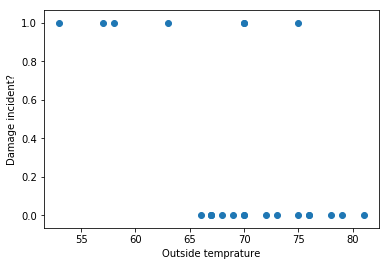

In [36]:
plt.scatter(challenger_data[:,0],challenger_data[:,1])
plt.ylabel("Damage incident?")
plt.xlabel("Outside temprature")

故障発生確率をロジスティック関数を用いて表す

In [107]:
def logit(x, beta, alpha):
    return 1.0 / (1.0 + np.exp(np.dot(beta,x) + alpha))

In [105]:
temperature = challenger_data[:,0]  # 説明変数
D = challenger_data[:,1]  # 目的変数

beta = pm.Normal("beta", 0, 0.001, value=0)  # init value=mu
alpha = pm.Normal("alpha", 0, 0.001, value=0)  # init value=mu

@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 / (1.0 + np.exp(beta * t + alpha))

pの事前確率は全て0.5（完全にランダム）

In [89]:
p.value

array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5])

観測結果は0,1なので、確率値＝pのベルヌーイ分布に従う。

In [92]:
obs = pm.Bernoulli("obs", p, value=D, observed=True)

In [95]:
model = pm.Model([obs, beta, alpha])

# sampling
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000,100000,2)

 [-----------------100%-----------------] 120000 of 120000 complete in 7.2 sec

データ数が少ないため、分布がばらついている。

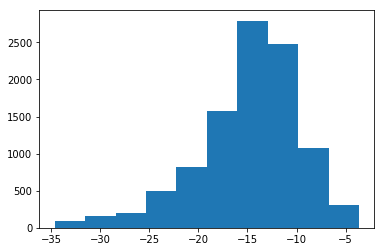

In [97]:
posterior_alpha = mcmc.trace('alpha')[:]
plt.hist(posterior_alpha)
plt.show()

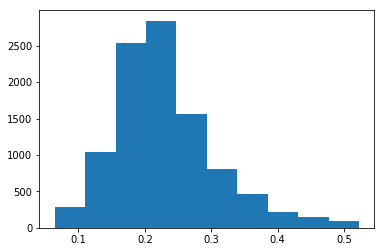

In [98]:
posterior_beta = mcmc.trace('beta')[:]
plt.hist(posterior_beta)
plt.show()

期待確率の分布

In [116]:
posterior_alpha = mcmc.trace('alpha')[:, None]
posterior_beta = mcmc.trace('beta')[:, None]
t = np.linspace(temperature.min()-5, temperature.max()+5, 50)[:,None]
p_t = logit(t.T, posterior_beta, posterior_alpha)  # サンプル毎の確率
mean_prob_t = p_t.mean(axis=0)

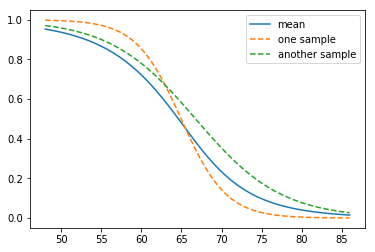

In [130]:
plt.plot(t, mean_prob_t, label="mean")  # 全サンプルの平均で描画した曲線
plt.plot(t, p_t[0,:],ls="--", label="one sample")  # あるサンプルで描画した曲線
plt.plot(t, p_t[-1,:],ls="--", label="another sample")  # 別のサンプルで描画した曲線
plt.legend()

95%信頼区間の計算

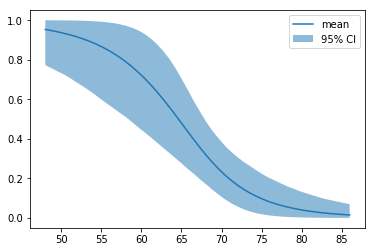

In [150]:
from scipy.stats.mstats import mquantiles
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:,0],*qs, alpha=0.5, label="95% CI")
plt.plot(t, mean_prob_t, label="mean")
plt.legend()

推定したモデルより、気温31度での事後確率を求める。

(array([  2.00000000e+00,   1.60000000e+01,   8.00000000e+00,
          1.60000000e+01,   2.10000000e+01,   3.10000000e+01,
          6.30000000e+01,   1.07000000e+02,   3.98000000e+02,
          9.33800000e+03]),
 array([ 0.79855721,  0.81870148,  0.83884576,  0.85899004,  0.87913432,
         0.8992786 ,  0.91942288,  0.93956716,  0.95971143,  0.97985571,
         0.99999999]),
 <a list of 10 Patch objects>)

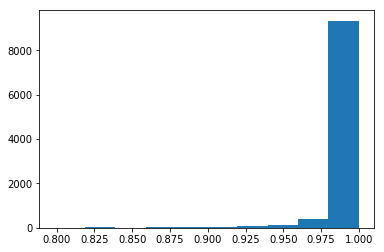

In [152]:
prob_31 = logit(31, posterior_beta, posterior_alpha)
plt.hist(prob_31)